# <span style='color:red'>Problem Set 2: Working with Financial Data</span>

## Instructions:

- **Make a copy of this notebook somewhere under the root-folder *except* for the shared-folder**
  - In JHub we have read-only access to the material under /shared
  - Everything else is associated with your DartmouthID and so only you can see them and they are permanent
- Enter the answers directly on this notebook
  - In most cases, you just need to execute the code and leave the output as it is
- All of the code you need can be found in Topics #2 and #3 notebooks
- When you are done, select "Print..." from the File-menu and create a PDF of the notebook
  - Submit this notebook through canvas
  - You can also submit the notebook as an .html file -- but please don't submit it as a notebook (.ipynb) file

# Problem 1: Magnificent Seven

### a) Download daily data from Yahoo finance for the "magnificent seven" stocks for 2023:

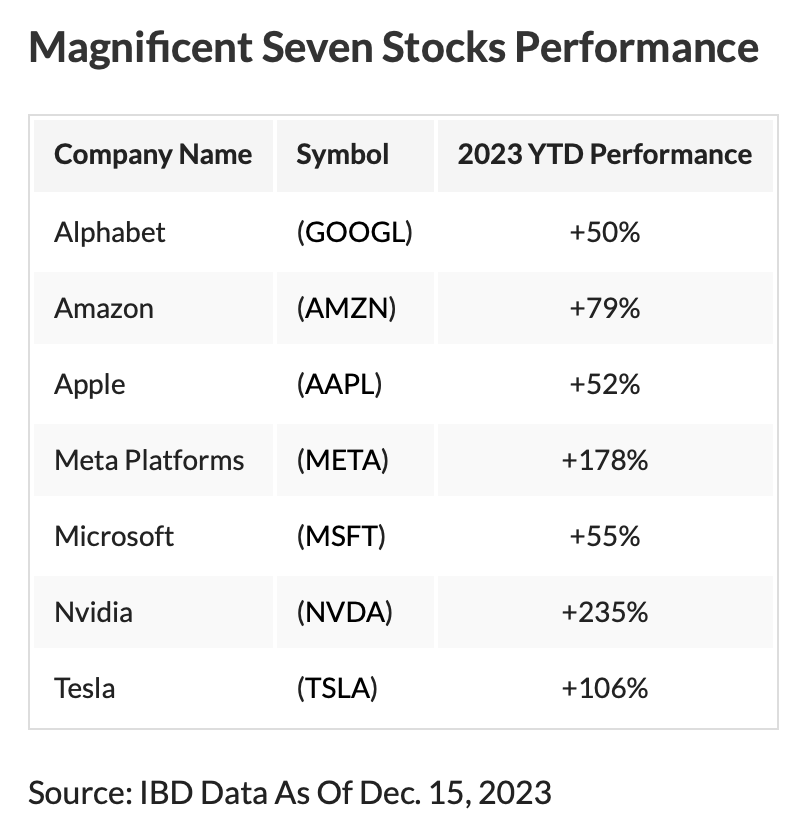

Compute and report the average daily returns for these stocks in 2023

Hint: if you do 

```from datetime import datetime```

you can set the start and end dates by writing

```
start_date = datetime(2022,12,30)
end_date = datetime(2023,12,31)
```
If you compute *returns* from the data that you get, it'll exactly cover 2023

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

# Create a list that contains the tickers we want to retrieve
ticker_symbols = ['GOOGL', 'AMZN', 'AAPL', 'META', 'MSFT', 'NVDA', 'TSLA']

# Define the start and end dates for the data
start_date = datetime(2022,12,30)
end_date = datetime(2023,12,31)

# Download the data for each stock
stock_data = yf.download(ticker_symbols, start=start_date, end=end_date)

# Print the first few rows of the downloaded data
print(stock_data.iloc[:4,:4])

returns = stock_data.xs('Adj Close', axis=1, level=0).pct_change()
returns.mean()

[*********************100%***********************]  7 of 7 completed
             Adj Close                                  
                  AAPL       AMZN      GOOGL        META
Date                                                    
2022-12-30  129.043121  84.000000  88.230003  120.339996
2023-01-03  124.216301  85.820000  89.120003  124.739998
2023-01-04  125.497498  85.139999  88.080002  127.370003
2023-01-05  124.166641  83.120003  86.199997  126.940002


AAPL     0.001678
AMZN     0.002588
GOOGL    0.002022
META     0.004621
MSFT     0.001960
NVDA     0.005338
TSLA     0.003387
dtype: float64

### b) What was the *median* number of shares traded -- that is, median volume -- in 2023 for these seven stocks?

Hints: 
- You have the Yahoo finance data
- Instead of picking the "Adj Close" information with .xs(), pick "Volume"
- If the resulting dataframe is called, say, df, you can compute medians by writing ```df.median()```

In [3]:
stock_data.xs('Volume', axis=1, level=0).median()

AAPL      55209200.0
AMZN      54310500.0
GOOGL     29116700.0
META      20653200.0
MSFT      25052100.0
NVDA      43339700.0
TSLA     128818700.0
dtype: float64

### c) Create a new column "magnificent" that is the return on a portfolio that invests an equal amount into each stock and rebalances daily 

Report the average daily return for this "magnificent" portfolio.

Hint: If you have a dataframe with the returns, this is *really* simple. Just like Topic2, you just need to write something like

```df['index'] = df.mean(axis=1)```

and you're done. This *is* the return on an equal-weighted portfolio of the seven socks.

In [4]:
returns['magnificent'] = returns.mean(axis=1)
returns['magnificent'].mean()

0.003085008263291157

### d) Compute and plot the cumulative sum of returns for the "magnificent" portfolio

Hints:
- To compute the cumulative sum of returns, you can just write something like ```df['column'].cumsum()``` and you're done
- You can then follow that with some plot() command

<AxesSubplot:xlabel='Date'>

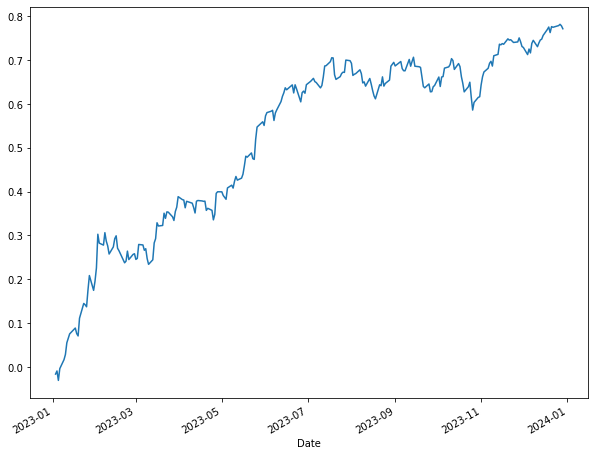

In [5]:
returns['magnificent'].cumsum().plot(figsize=(10,8))

### e) Compute and report the annualized Sharpe ratio for this portfolio in 2023

In [6]:
ir = np.sqrt(252) * returns['magnificent'].mean() / returns['magnificent'].std()
print(f'IR = {ir:.2f}')

IR = 2.98


# Problem 2: Short-Term Reversals

### a) Instead of using 10th and 90th percentiles as the breakpoints, what is the Sharpe ratio if we use 20th and 80th percentiles instead?

Please use the same "up to December 1995" sample that we studied in Topic 3

What you need to do:
1. Start from Topic 3 notebook
2. Execute enough code to get the Sharpe ratio of the "strev" strategy 
3. Modify the code to change the breakpoints to 20 and 80 

In practice, there is often a trade-off when you broaden the portfolios:
- The signal might not work as well because we are not focusing on as extreme winners and losers
- *However*, our portfolios now have more stocks so they are better diversfied

*NOTE:* You do no need to copy the code here. You can just write the answer below as text.

## Answer

The code below creates both the original and modified strategy. It puts the resulting monthly returns into a dictionary.

In [12]:
df = pd.read_pickle('data/crsp.pkl')

alternative_breakpoints = {'original': [20, 80],
                          'modified': [10, 90]}

# I'll put the alternative strategy returns into this dictionary
strev = {}

for specification in alternative_breakpoints:
    
    lb, ub = alternative_breakpoints[specification]

    grp = df['ret'].dropna().groupby(level=1)
    p_lb = grp.apply(lambda x: np.percentile(x, lb))
    p_ub = grp.apply(lambda x: np.percentile(x, ub))
    breakpoints = pd.DataFrame({'lb': p_lb, 'ub': p_ub})

    df = df.merge(breakpoints, left_on='date', right_index=True, how='left')
    df['long'] = (df['ret'] <= df['lb']).astype('int')
    df['short'] = (df['ret'] >= df['ub']).astype('int')
    ns = df[['long','short']].groupby(level='date').sum()

    weights = df[['long','short']] / ns

    df = df.drop(columns=['lb', 'ub', 'long', 'short']).merge(weights,left_index=True,right_index=True)

    w = df[['long', 'short']].groupby(level='PERMNO').shift(1)

    portfolio_returns = w.mul(df['ret'], axis=0).groupby(level='date').sum(min_count=1)
    strev[specification] = portfolio_returns['long'] - portfolio_returns['short']

In [17]:
for specification in strev:
    r = strev[specification].loc[:'1995-12']
    annual_sr = np.sqrt(12) * r.mean() / r.std()
    print(f'Specification {specification}: Sharpe ratio = {annual_sr:.2f}')

Specification original: Sharpe ratio = 1.89
Specification modified: Sharpe ratio = 2.32


**Answer:**

- The original strategy's annualized Sharpe ratio is 1.89 in the "up to December 1995" sample 

- The modified strategy's Sharpe ratio is 2.32

### b) What happens if...?

This one line in Topic3 code determines the timing when we construct the equal-weighted strategy:

```w = df[['long', 'short']].groupby(level='PERMNO').shift(1)```

**shift(1)** on this line determines that we shift weights back one month relative to returns

What this means in terms of determining the strategy is that:

- We compute the portfolio weights in month t and
- We then hold these portfolios in month t+1

Change this code so that you shift weights back not by 1 month but by **12** months

Rerun the code. 

#### <span style='color:red'>Questions:</span>

1. **What is the Sharpe Ratio of the resulting strategy?**
2. Your strategy is still a reversals strategy: you buy past losers and sell past winners, but now you're looking exactly one year back in time. **Based on what you see, do you think it is a good idea to bet that returns exactly a year ago reverse this month---or what trading rule might be profitable?**

Specification modified: Sharpe ratio = -1.33


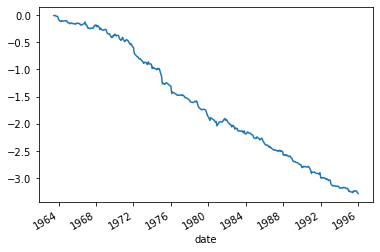

In [19]:
df = pd.read_pickle('data/crsp.pkl')

alternative_breakpoints = {'original': [20, 80],
                          'modified': [10, 90]}

# I'll put the alternative strategy returns into this dictionary
strev_more_lag = {}

for specification in alternative_breakpoints:
    
    lb, ub = alternative_breakpoints[specification]

    grp = df['ret'].dropna().groupby(level=1)
    p_lb = grp.apply(lambda x: np.percentile(x, lb))
    p_ub = grp.apply(lambda x: np.percentile(x, ub))
    breakpoints = pd.DataFrame({'lb': p_lb, 'ub': p_ub})

    df = df.merge(breakpoints, left_on='date', right_index=True, how='left')
    df['long'] = (df['ret'] <= df['lb']).astype('int')
    df['short'] = (df['ret'] >= df['ub']).astype('int')
    ns = df[['long','short']].groupby(level='date').sum()

    weights = df[['long','short']] / ns

    df = df.drop(columns=['lb', 'ub', 'long', 'short']).merge(weights,left_index=True,right_index=True)

    w = df[['long', 'short']].groupby(level='PERMNO').shift(12)

    portfolio_returns = w.mul(df['ret'], axis=0).groupby(level='date').sum(min_count=1)
    strev_more_lag[specification] = portfolio_returns['long'] - portfolio_returns['short']
    
r = strev_more_lag['original'].loc[:'1995-12']
annual_sr = np.sqrt(12) * r.mean() / r.std()
print(f'Specification {specification}: Sharpe ratio = {annual_sr:.2f}')
    
r.cumsum().plot();

**Answer to 1:** If we instead lag the signal by 12 months, we do not get reversals. The Sharpe ratio of the strategy is now -1.33

**Answer to 2:** This result suggests that stock returns do not reverse at this lag. In fact, we know from the literature that:

- Stock returns display reversals at 1-2 month lags
- They display momentum from lag 3-12
- They display long-term reversals at higher lags

In addition, stock returns also have **seasonalities** which show up as momentum in analyses such as these when the lag is an exact multiple of 12. That is, a stock that went up 12 months, 24 months, 36 months,... age is likely to go up relative to stocks that went down. 